In [1]:
from pathlib import Path
import random
import itertools
from collections import Counter
import joblib
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [2]:
# # load metadata 
# metadata_file = Path('/home/palonso/data/discotube/metadata/discogs_20200901_releases.json.clean.youtube')
# metadata = pd.read_json(metadata_file, lines=True).set_index(0)

In [3]:
# analysis parameters
min_samples_per_tag = 15  # minimum number of samples per tag for every subset  
max_n_tags = 5  # maximum number of tags per track. Tracks with more tags can be considered too unespecific
top_n = 500  # the number of tags to consider ordered by popularity

# the test subset 
test_subset_name = '50k'
test_split_size = 50000

# validation split ratio
val_ratio = .10

seed = 10
random.seed(seed)

# path config
out_dir = Path('../../out')
dt_base = Path('/mnt/projects/discotube/discotube-2020-09/')
filelists = dt_base / 'discogs_20200901_releases.json.clean.youtube.ids.random.??'
metadata_pickle_file = '/scratch/palonso/data/discotube/discotube_metadata.pkl'

ids_file = out_dir / 'ids'
existing_ids_file = out_dir / 'existing_ids'

In [4]:
# serialize metadata to a pickle for faster load 
# metadata.to_pickle(metadata_pickle_file)

In [5]:
metadata = pd.read_pickle(metadata_pickle_file)

In [6]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5095522 entries, MpmbntGDyNE to B8nSNrCDBjM
Data columns (total 1 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   1       object
dtypes: object(1)
memory usage: 77.8+ MB


In [7]:
metadata.head()

,1
0,
MpmbntGDyNE,"{'1': {'genres': ['Electronic'], 'styles': ['E..."
Cawyll0pOI4,"{'1': {'genres': ['Electronic'], 'styles': ['E..."
XExCZfMCXdo,"{'1': {'genres': ['Electronic'], 'styles': ['E..."
WDZqiENap_U,"{'1': {'genres': ['Electronic'], 'styles': ['E..."
EBBHR3EMN50,"{'1': {'genres': ['Electronic'], 'styles': ['E..."


In [8]:
metadata.sample()[1][0]

{'7970781': {'genres': ['Rock'],
  'styles': ['Rock---Black Metal'],
  'released': 2016,
  'country': 'France',
  'artists': ['4313824'],
  'labels': ['Hass Weg Productions']}}

In [9]:
# get the ids files

In [10]:
!cat {filelists} > {ids_file}
!find /home/palonso/data/discotube/discotube-specs/ -type f | cut -d '/' -f 7- > {existing_ids_file}

In [11]:
# load ids. We can decide wether to use all the ids or only the ones found in this machine
with open (existing_ids_file, 'r') as f:
    ids = set([l.rstrip() for l in f.readlines()])

In [12]:
def key2id(key):
    return key.split('.')[0][3:]

In [13]:
#  as we are in the middle of the download process we should skip potential temp files
for i in ids:
    if i.endswith('.temp'):
        ids.discard(i)

ids.discard('log')

key2id_dict = {i: key2id(i) for i in ids}

In [14]:
sample = metadata.sample()[1][0]
sample

{'12592365': {'genres': ['Rock'],
  'styles': ['Rock---Alternative Rock'],
  'released': 2018,
  'country': 'Denmark',
  'artists': ['5296640'],
  'labels': ['Bad Afro Records', 'Third Coming Records']}}

In [15]:
def get_tags(entry):
    tags = set()
    for v in entry.values():

        for s in v['styles']:
            tags.add(s)
    if tags: 
        return tags
    else:
        return None

print(get_tags(sample))

tag_dict = {i: get_tags(metadata.loc[key2id_dict[i]][1]) for i in ids}

{'Rock---Alternative Rock'}


In [16]:
tag_dict = {k: v for k, v in tag_dict.items() if v}

ids_clean = set(tag_dict.keys())

print(f'{len(ids - ids_clean)} ids descarted due to missing style tags')

ids = ids_clean

85716 ids descarted due to missing style tags


In [17]:
tag_dict = {k: v for k, v in tag_dict.items() if len(v) <= max_n_tags}

ids_clean = set(tag_dict.keys())

print(f'{len(ids - ids_clean)} ids descarted due to too many style tags')

ids = ids_clean

59816 ids descarted due to too many style tags


In [18]:
print(f'{len(ids)} available ids')

913319 available ids


In [19]:
# get the year of the first release attached to the id

def get_year(entry):
    years = []
    for v in entry.values():
        if type(v['released']) == int:
            years.append(v['released'])
    if years:
        return min(years)
    else: 
        return 0

print(get_year(sample))

year_dict = {id: get_year(metadata.loc[key2id_dict[id]][1]) for id in ids}

2018


(577) tags


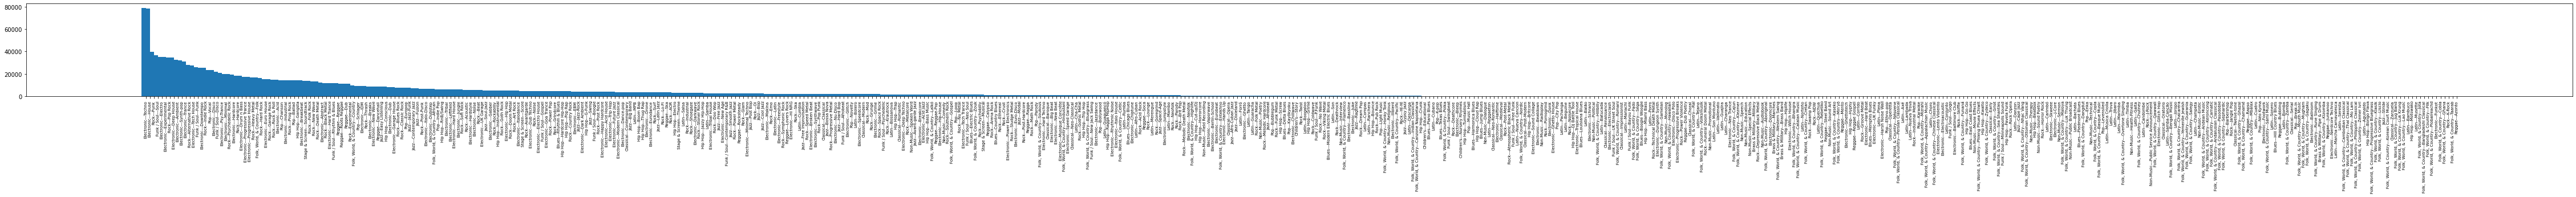

In [20]:
# get tag distribution
cum_tags = list(itertools.chain.from_iterable([list(v) for v in tag_dict.values()]))

counts = Counter(cum_tags)
tags, values = zip(*(counts.most_common()))
print(f'({len(counts)}) tags')

indexes = np.arange(len(tags))
width = 1
plt.figure(figsize=[80, 3])
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, tags, rotation='vertical', size=7)
plt.show()

In [21]:
# top tags
print('top tags:\n', list(zip(tags[:100], values[:100])))

# discard less popular tags
top_tags = tags[:top_n]
print('discarded tags:\n', list(zip(tags[top_n:], values[top_n:])))
print('less popular tags:\n', list(zip(tags[top_n -50: top_n], values[top_n -50: top_n])))

top tags:
 [('Electronic---Techno', 78830), ('Electronic---House', 78397), ('Rock---Punk', 39874), ('Funk / Soul---Soul', 36525), ('Electronic---Electro', 35313), ('Electronic---Experimental', 35157), ('Rock---Pop Rock', 34747), ('Electronic---Deep House', 34736), ('Electronic---Ambient', 32549), ('Electronic---Synth-pop', 32003), ('Electronic---Trance', 31185), ('Rock---Alternative Rock', 28172), ('Electronic---Tech House', 27314), ('Funk / Soul---Funk', 26143), ('Electronic---Downtempo', 25690), ('Rock---Indie Rock', 25325), ('Pop---Vocal', 23691), ('Electronic---Disco', 23477), ('Funk / Soul---Disco', 22063), ('Electronic---Psy-Trance', 20716), ('Electronic---Minimal', 20138), ('Rock---Psychedelic Rock', 19790), ('Electronic---Hardcore', 19626), ('Rock---Hardcore', 18588), ('Electronic---Drum n Bass', 18284), ('Electronic---Progressive Trance', 17297), ('Electronic---Progressive House', 17207), ('Rock---Heavy Metal', 16916), ('Folk, World, & Country---Folk', 16810), ('Rock---Hard Ro

In [22]:
filtered_labels = set(top_tags)
filtered_tag_dict = dict()

for k, v in tag_dict.items():
    new_v = v.intersection(filtered_labels)
    if v:
        filtered_tag_dict[k] = new_v

print(f'discarded ({len(tag_dict) - len(filtered_tag_dict)}) items due to the tag filter')

discarded (0) items due to the tag filter


In [23]:
# double check the final number of tags
tags_clean = set()
for v in filtered_tag_dict.values():
    tags_clean.update(set(v))
    
print(f'({len(tags_clean)}) tags considered')

(500) tags considered


In [24]:
# Enconde tags
lb = preprocessing.MultiLabelBinarizer()
lb.fit([list(top_tags)])
joblib.dump(lb, out_dir / 'encoder_top500.joblib')

lb.classes_

array(['Blues---Boogie Woogie', 'Blues---Chicago Blues',
       'Blues---Country Blues', 'Blues---Delta Blues',
       'Blues---East Coast Blues', 'Blues---Electric Blues',
       'Blues---Harmonica Blues', 'Blues---Jump Blues',
       'Blues---Louisiana Blues', 'Blues---Memphis Blues',
       'Blues---Modern Electric Blues', 'Blues---Piano Blues',
       'Blues---Piedmont Blues', 'Blues---Rhythm & Blues',
       'Blues---Texas Blues', 'Brass & Military---Brass Band',
       'Brass & Military---Marches', 'Brass & Military---Military',
       "Children's---Educational", "Children's---Nursery Rhymes",
       "Children's---Story", 'Classical---Baroque', 'Classical---Choral',
       'Classical---Classical', 'Classical---Contemporary',
       'Classical---Early', 'Classical---Impressionist',
       'Classical---Medieval', 'Classical---Modern',
       'Classical---Neo-Classical', 'Classical---Neo-Romantic',
       'Classical---Opera', 'Classical---Operetta',
       'Classical---Post-Modern',

In [25]:
from collections import defaultdict
from collections import OrderedDict

# get artists information
def get_artists(entry):
    artists = set()
    for v in entry.values():
        artists.update(v['artists'])
    return artists 

artists_map = defaultdict(set)
for id in tqdm(ids):
    artists = get_artists(metadata.loc[key2id_dict[id]][1])
    for a in artists:
        artists_map[a].add(id)
        
# artist map ordered by the number or tracks. This way we can prioritice
# single release artists to encourage diversity and prevent `artist bleeding`
artists_map_ordered = OrderedDict(sorted(artists_map.items(), key=lambda x:len(x[1])))

# avaiable artists
artists = set(artists_map.keys())

id2artist = defaultdict(set)
for artist, tracks in artists_map.items():
    for track in tracks:
        id2artist[track].add(artist)

100%|██████████| 913319/913319 [01:18<00:00, 11659.44it/s]


In [29]:
def fix_dataset(ids_set, available_ids, available_artists):
    years = [int(np.floor(year_dict[id] / 10) * 10) for id in ids_set]
    years_counts = Counter(years)
    years_counts_labels, years_counts_values = zip(*(years_counts.most_common()))
    print(f' releases from ({len(years_counts)}) differnt decades')
    
    indexes = np.arange(len(years_counts_labels))
    width = 1
    plt.figure(figsize=[20, 3])
    plt.bar(indexes, years_counts_values, width)
    plt.xticks(indexes + width * 0.5, years_counts_labels, rotation='vertical', size=7)
    plt.show()

    print('decades counts:\n', list(zip(years_counts_labels, years_counts_values)))

    tags = list(itertools.chain.from_iterable([filtered_tag_dict[v] for v in ids_set]))
    tag_counts = Counter(tags)
    tag_counts_labels, tag_counts_values = zip(*(tag_counts.most_common()))

    print(f' ({len(tag_counts)}) differnt tags')
    print('20 less popular tags before compensation:\n', list(zip(tag_counts_labels[-20:], tag_counts_values[-20:])))

    # tag compensation. Make sure every tag apears at least 10 times
    print(f'tag compensation: each tag should appear at least ({min_samples_per_tag}) times')
    missing_tags = tags_clean - set(tag_counts_labels)

    tag_counts_labels = list(tag_counts_labels)
    tag_counts_values = list(tag_counts_values)

    tag_counts_labels += missing_tags
    tag_counts_values += [0] * len(missing_tags)

    available_ids = available_ids - ids_set
    #     random.shuffle(available_ids)
    
    artists_compensation = set()

    print('first compensation round. No artist bleeding allowed')
    compensation_ids = set()
    for tag, count in zip(tag_counts_labels, tag_counts_values):
        if count < min_samples_per_tag:
            remaining = min_samples_per_tag - count
            for artist, tracks in artists_map_ordered.items():
                if artist in available_artists:
                    for i in tracks:
                        if i in available_ids:
                            if tag in filtered_tag_dict[i]:
                                if i not in compensation_ids:
                                    compensation_ids.add(i)
                                    artists_compensation.add(artist)
                                    remaining -= 1
                                    if remaining == 0:
                                        break
                    if remaining == 0:
                        break

    print(f'used ({len(compensation_ids)}) ids to populate scarce tags')

    ids_set.update(compensation_ids)
    print(f'subset size after first compensation: {len(ids_set)}')


    tags = list(itertools.chain.from_iterable([filtered_tag_dict[v] for v in ids_set]))
    tag_counts = Counter(tags)
    tag_counts_labels, tag_counts_values = zip(*(tag_counts.most_common()))

    if tag_counts_values[-1] != min_samples_per_tag:
        print('second compensation round. Artist bleeding allowed!')
        print('20 less popular tags before compensation:\n', list(zip(tag_counts_labels[-20:], tag_counts_values[-20:])))

        tag_counts_labels = list(tag_counts_labels)
        tag_counts_values = list(tag_counts_values)

        available_ids -= ids_set

        compensation_ids = set()
        for tag, count in zip(tag_counts_labels, tag_counts_values):
            if count < min_samples_per_tag:
                remaining = min_samples_per_tag - count
                for artist, tracks in artists_map_ordered.items():
                    for i in tracks:
                        if i in available_ids:
                            if tag in filtered_tag_dict[i]:
                                if i not in compensation_ids:
                                    compensation_ids.add(i)
                                    artists_compensation.add(artist)
                                    remaining -= 1
                                    if remaining == 0:
                                        break
                    if remaining == 0:
                        break
 
        print(f'used ({len(compensation_ids)}) ids to populate scarce tags')

        ids_set.update(compensation_ids)
        print(f'subset size after compensation: {len(ids_set)}')
        
        test_cum_tags = list(itertools.chain.from_iterable([list(filtered_tag_dict[v]) for v in ids_set]))

        counts = Counter(test_cum_tags)
        tags, values = zip(*(counts.most_common()))
        print('20 less popular tags after second compensation:\n', list(zip(tags[-20:], values[-20:])))

    else:
        print(f'tags: {len(tag_counts_labels)}')
        print('a second compensation was not required\n')

    return ids_set, artists_compensation

ids with single track: 160891
 releases from (14) differnt decades


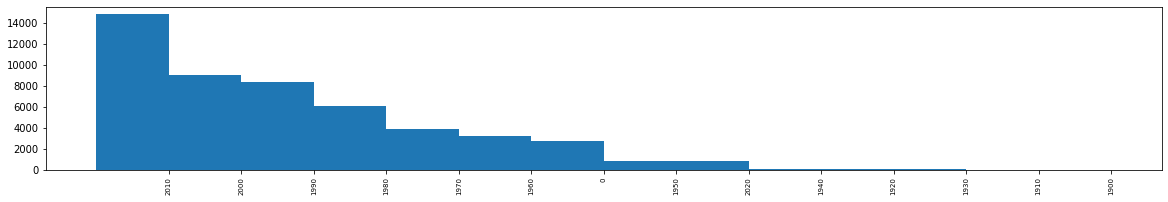

decades counts:
 [(2010, 14795), (2000, 9021), (1990, 8367), (1980, 6124), (1970, 3882), (1960, 3179), (0, 2699), (1950, 833), (2020, 828), (1940, 109), (1920, 76), (1930, 65), (1910, 15), (1900, 7)]
 (498) differnt tags
20 less popular tags before compensation:
 [('Rock---J-Rock', 3), ('Rock---Horror Rock', 3), ('Folk, World, & Country---Griot', 3), ('Blues---East Coast Blues', 3), ('Non-Music---Movie Effects', 3), ('Latin---Trova', 3), ('Latin---Timba', 2), ('Blues---Memphis Blues', 2), ('Rock---Industrial Metal', 2), ('Folk, World, & Country---Nhạc Vàng', 2), ('Folk, World, & Country---Sea Shanties', 2), ('Electronic---Baltimore Club', 2), ('Latin---Conjunto', 2), ('Electronic---Skweee', 2), ('Electronic---Lento Violento', 2), ('Folk, World, & Country---Phleng Phuea Chiwit', 1), ('Electronic---Ghettotech', 1), ('Electronic---J-Core', 1), ('Funk / Soul---Minneapolis Sound', 1), ('Non-Music---Public Broadcast', 1)]
tag compensation: each tag should appear at least (15) times
first com

In [27]:
ids_singletrack = set()

for _, tracks in artists_map_ordered.items():
    ids_singletrack.update(tracks)
    if len(tracks) >= 2:
        break
        
print(f'ids with single track: {len(ids_singletrack)}')

random.seed(seed)
ids_test = set(random.sample(list(ids_singletrack), test_split_size))

artists_test = set()
for i in ids_test:
    artists_test.update(id2artist[i])

ids_test, artists_compensation_test = fix_dataset(ids_test, ids, artists)

mlb_labels_test = {k: lb.transform([list(filtered_tag_dict[k])])[0].astype('bool') for k in ids_test}

pickle_file = out_dir / f'gt_test_{test_subset_name}.pk'
pickle.dump(mlb_labels_test, open(pickle_file ,'wb'))

processing validation set "50k". Targeting (5000) samples
available ids: 862324
collected val ids: 5000
 releases from (14) differnt decades


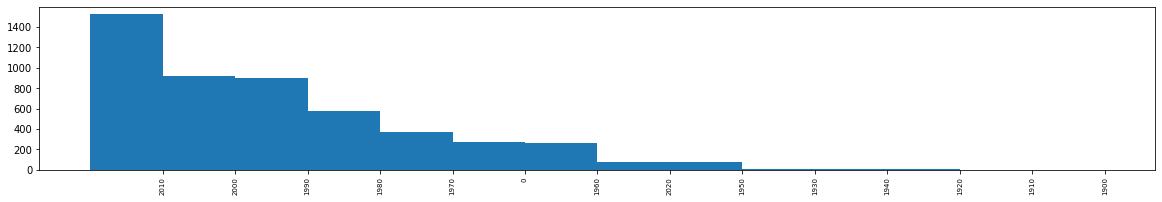

decades counts:
 [(2010, 1521), (2000, 918), (1990, 897), (1980, 575), (1970, 370), (0, 273), (1960, 265), (2020, 80), (1950, 79), (1930, 7), (1940, 6), (1920, 6), (1910, 2), (1900, 1)]
 (370) differnt tags
20 less popular tags before compensation:
 [('Non-Music---Interview', 1), ('Latin---Ranchera', 1), ('Hip Hop---Crunk', 1), ('Electronic---Bleep', 1), ('Rock---Brit Pop', 1), ('Latin---Guajira', 1), ('Folk, World, & Country---Klezmer', 1), ('Reggae---Steel Band', 1), ('Blues---Piano Blues', 1), ('Latin---Batucada', 1), ('Funk / Soul---Swingbeat', 1), ('Folk, World, & Country---Nordic', 1), ('Electronic---Tropical House', 1), ('Non-Music---Audiobook', 1), ('Non-Music---Sound Art', 1), ('Blues---Louisiana Blues', 1), ('Electronic---Ghetto House', 1), ('Latin---Beguine', 1), ('Pop---Music Hall', 1), ('Jazz---Gypsy Jazz', 1)]
tag compensation: each tag should appear at least (15) times
first compensation round. No artist bleeding allowed
used (4089) ids to populate scarce tags
subset siz

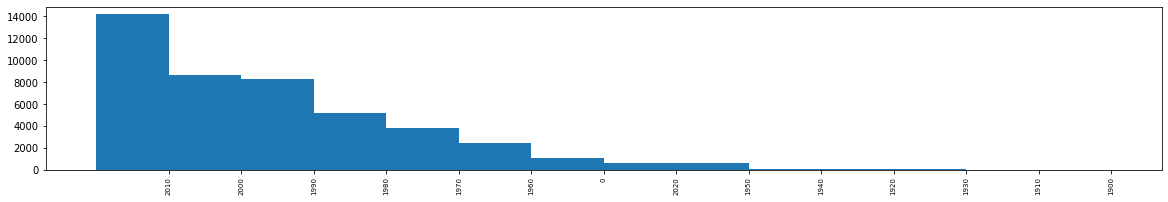

decades counts:
 [(2010, 14183), (2000, 8634), (1990, 8308), (1980, 5158), (1970, 3822), (1960, 2428), (0, 1074), (2020, 663), (1950, 585), (1940, 72), (1920, 33), (1930, 30), (1910, 7), (1900, 3)]
 (489) differnt tags
20 less popular tags before compensation:
 [('Latin---Carimbó', 2), ('Latin---Timba', 2), ('Folk, World, & Country---Maloya', 2), ('Reggae---Dub Poetry', 2), ('Jazz---Cape Jazz', 1), ('Non-Music---Sound Poetry', 1), ('Latin---Trova', 1), ('Folk, World, & Country---Chinese Classical', 1), ('Folk, World, & Country---Copla', 1), ('Latin---Candombe', 1), ('Hip Hop---Go-Go', 1), ('Latin---Bachata', 1), ('Electronic---Electroacoustic', 1), ('Folk, World, & Country---Ottoman Classical', 1), ('Non-Music---Sermon', 1), ('Electronic---Baltimore Club', 1), ("Folk, World, & Country---Min'yō", 1), ('Latin---Choro', 1), ('Folk, World, & Country---Nhạc Vàng', 1), ('Rock---J-Rock', 1)]
tag compensation: each tag should appear at least (15) times
first compensation round. No artist bleed

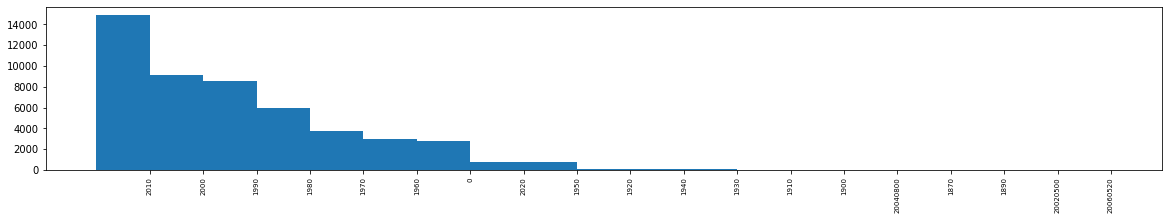

decades counts:
 [(2010, 14917), (2000, 9123), (1990, 8595), (1980, 5960), (1970, 3758), (1960, 3017), (0, 2755), (2020, 797), (1950, 797), (1920, 91), (1940, 88), (1930, 71), (1910, 16), (1900, 10), (20040800, 1), (1870, 1), (1890, 1), (20020500, 1), (20060520, 1)]
 (425) differnt tags
20 less popular tags before compensation:
 [('Rock---Skiffle', 4), ('Latin---Charanga', 3), ('Hip Hop---Go-Go', 3), ('Reggae---Mento', 3), ('Electronic---Neo Trance', 3), ('Pop---Karaoke', 2), ('Folk, World, & Country---Mizrahi', 2), ('Pop---City Pop', 2), ('Folk, World, & Country---Catalan Music', 2), ('Folk, World, & Country---Bhangra', 2), ('Hip Hop---Kwaito', 2), ('Classical---Neo-Romantic', 2), ('Hip Hop---Miami Bass', 1), ('Reggae---Dub Poetry', 1), ('Folk, World, & Country---Luk Thung', 1), ('Latin---Quechua', 1), ('Reggae---Reggae Gospel', 1), ('Latin---Norteño', 1), ('Latin---Nueva Cancion', 1), ('Folk, World, & Country---Basque Music', 1)]
tag compensation: each tag should appear at least (15)

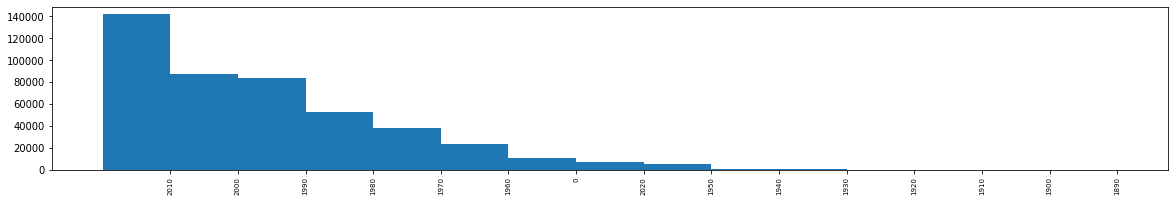

decades counts:
 [(2010, 141532), (2000, 87249), (1990, 83611), (1980, 52524), (1970, 38159), (1960, 23372), (0, 10319), (2020, 6865), (1950, 5198), (1940, 542), (1930, 302), (1920, 247), (1910, 61), (1900, 16), (1890, 3)]
 (500) differnt tags
20 less popular tags before compensation:
 [('Latin---Jibaro', 18), ('Folk, World, & Country---Maloya', 17), ('Pop---Enka', 17), ('Folk, World, & Country---Nhạc Vàng', 16), ('Electronic---J-Core', 16), ('Non-Music---Therapy', 16), ('Latin---Timba', 15), ('Latin---Marimba', 14), ('Jazz---Cape Jazz', 13), ('Latin---Música Criolla', 13), ('Latin---Trova', 12), ('Folk, World, & Country---Chutney', 12), ('Rock---J-Rock', 11), ('Folk, World, & Country---Overtone Singing', 11), ('Latin---Candombe', 10), ('Latin---Carimbó', 9), ('Latin---Gaita', 6), ('Non-Music---Technical', 5), ('Non-Music---Health-Fitness', 5), ('Non-Music---Public Broadcast', 5)]
tag compensation: each tag should appear at least (15) times
first compensation round. No artist bleeding 

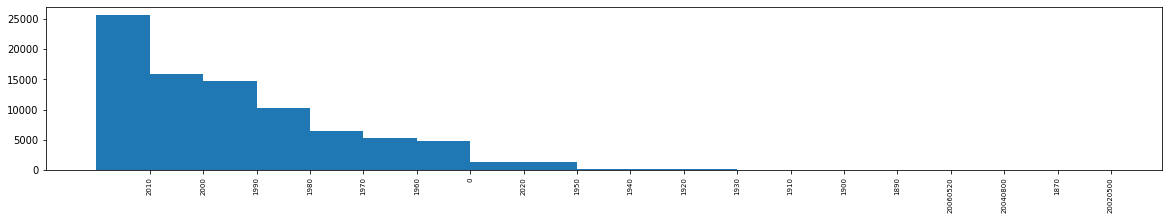

decades counts:
 [(2010, 25703), (2000, 15852), (1990, 14733), (1980, 10270), (1970, 6491), (1960, 5245), (0, 4764), (2020, 1377), (1950, 1349), (1940, 148), (1920, 148), (1930, 104), (1910, 31), (1900, 12), (1890, 1), (20060520, 1), (20040800, 1), (1870, 1), (20020500, 1)]
 (456) differnt tags
20 less popular tags before compensation:
 [('Funk / Soul---Gogo', 3), ('Electronic---Hard Beat', 3), ('Latin---Plena', 3), ('Latin---Axé', 3), ('Latin---Quechua', 3), ('Folk, World, & Country---Mizrahi', 3), ('Folk, World, & Country---Gamelan', 3), ('Latin---Danzon', 2), ('Latin---Lambada', 2), ('Folk, World, & Country---Zydeco', 2), ('Electronic---Doomcore', 2), ('Pop---Enka', 2), ('Jazz---Cape Jazz', 2), ('Electronic---UK Funky', 2), ('Latin---Corrido', 2), ('Electronic---Schranz', 1), ('Folk, World, & Country---Appalachian Music', 1), ('Pop---Levenslied', 1), ('Latin---Candombe', 1), ('Classical---Early', 1)]
tag compensation: each tag should appear at least (15) times
first compensation rou

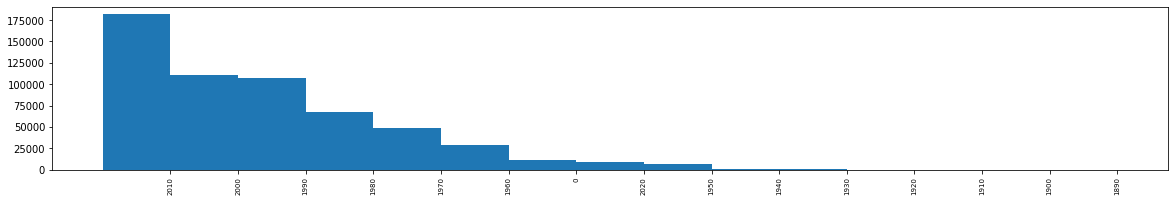

decades counts:
 [(2010, 181495), (2000, 110429), (1990, 107484), (1980, 67579), (1970, 48640), (1960, 29113), (0, 11965), (2020, 8764), (1950, 6360), (1940, 660), (1930, 354), (1920, 260), (1910, 68), (1900, 22), (1890, 3)]
 (500) differnt tags
20 less popular tags before compensation:
 [('Latin---Jibaro', 23), ('Folk, World, & Country---Dangdut', 22), ('Folk, World, & Country---Copla', 22), ('Latin---Timba', 22), ('Pop---Levenslied', 21), ('Non-Music---Therapy', 21), ('Folk, World, & Country---Nhạc Vàng', 21), ('Electronic---J-Core', 21), ('Latin---Marimba', 20), ('Latin---Trova', 18), ('Rock---J-Rock', 16), ('Latin---Carimbó', 16), ('Folk, World, & Country---Overtone Singing', 16), ('Folk, World, & Country---Chutney', 15), ('Latin---Candombe', 14), ('Jazz---Cape Jazz', 13), ('Latin---Gaita', 9), ('Non-Music---Technical', 9), ('Non-Music---Public Broadcast', 7), ('Non-Music---Health-Fitness', 4)]
tag compensation: each tag should appear at least (15) times
first compensation round. N

In [30]:
dataset_sizes = [('50k', 50000), ('500k', 500000), ('all', len(ids - ids_test))]

for subset_name, subset_size in dataset_sizes:
    train_split_size = int(subset_size * (1 - val_ratio))
    val_split_size = int(subset_size * val_ratio)

    print(f'processing validation set "{subset_name}". Targeting ({val_split_size}) samples')
    # prevent using the same artist to populate the test split
    available_ids = ids - ids_test
    available_artists = artists - artists_test

    ids_val = set()
    artists_val = set()
    print('available ids:', len(available_ids))
    for _, tracks in artists_map_ordered.items():
        for i in tracks:
            if i in available_ids:
                if not artists_test.intersection(id2artist[i]):
                    ids_val.add(i)
                    artists_val.update(id2artist[i])
            if len(ids_val) >= val_split_size:
                break
        if len(ids_val) >= val_split_size:
                break

    print('collected val ids:', len(ids_val))
    ids_val, artists_compensation_val = fix_dataset(ids_val, set(available_ids), available_artists)

    print(f'processing train set "{subset_name}". Targeting ({train_split_size}) samples')
    # prevent using the same artist to populate the validation split
    available_ids = list(ids - ids_test - ids_val)
    available_artists = artists - artists_test - artists_val
    artists_test_val = artists_val.union(artists_test)

    random.seed(seed + 2)
    random.shuffle(available_ids)

    ids_train = set()
    artists_train = set()
    print('available ids:', len(available_ids))
    for i in available_ids:
        if not artists_test_val.intersection(id2artist[i]):
            ids_train.add(i)
            artists_train.update(id2artist[i])
            if len(ids_train) >= train_split_size:
                break
    print('collected train ids:', len(ids_train))
    # we can allow artist leakage for the correction. Otherwise it may be imposible to popule niche styles
    ids_train, artists_compensation_train = fix_dataset(ids_train, set(available_ids), available_artists)

    print('test/val artist intersection: ', len(artists_test.intersection(artists_val)))
    print('test/train artist intersection: ', len(artists_test.intersection(artists_train)))
    print('val/train artist intersection: ', len(artists_val.intersection(artists_train)))

    print('with compensation')
    print('test/val artist intersection: ', len(artists_test.union(artists_compensation_test).intersection(artists_val.union(artists_compensation_val))))
    print('test/train artist intersection: ', len(artists_test.union(artists_compensation_test).intersection(artists_train.union(artists_compensation_train))))
    print('val/train artist intersection: ', len(artists_val.union(artists_compensation_val).intersection(artists_train.union(artists_compensation_train))))

    assert not ids_train.intersection(ids_test), 'train/test id intersection'
    assert not ids_train.intersection(ids_val), 'train/val id intersection'
    assert not ids_test.intersection(ids_val), 'test/val id intersection'
    
    assert not artists_train.intersection(artists_test), 'train/test artist intersection'
    assert not artists_train.intersection(artists_val), 'train/val artist intersection'
    assert not artists_test.intersection(artists_val), 'test/val artist intersection'

    total_size = len(ids_train) + len(ids_val)

    print(f'train size: {len(ids_train)}, {100 * len(ids_train) / total_size:.1f}%')
    print(f'val size: {len(ids_val)}, {100 * len(ids_val) / total_size:.1f}%')
    print(f'total size: {len(ids_train) + len(ids_val)}')

    print('encoding labels')
    mlb_labels_train = {k: lb.transform([list(filtered_tag_dict[k])])[0].astype('bool') for k in ids_train}
    mlb_labels_val = {k: lb.transform([list(filtered_tag_dict[k])])[0].astype('bool') for k in ids_val}

    print('saving files')
    pickle_file = out_dir /  f'gt_train_{subset_name}.pk'
    pickle.dump(mlb_labels_train, open(pickle_file ,'wb'))

    pickle_file = out_dir / f'gt_val_{subset_name}.pk'
    pickle.dump(mlb_labels_val, open(pickle_file ,'wb'))
    print(f'done for "{subset_name}"\n')

In [ ]:
!ls -lh {out_dir}